## 1.3.1 欧式期权MC估算函数

In [9]:
import math
import numpy as np

In [10]:
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2

In [11]:
I = 1000000

In [12]:
# 固定种子值
np.random.seed(1000)

In [13]:
# 提取标准正态分布随机数
z = np.random.standard_normal(I)

In [14]:
%timeit ST = S0 * np.exp((r-sigma**2/2)*T + sigma * math.sqrt(T) * z)

8.69 ms ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
ST = S0 * np.exp((r-sigma**2/2)*T + sigma * math.sqrt(T) * z)
hT = np.maximum(ST-K,0)
C0 = math.exp(-r*T) * np.mean(hT)
C0

8.01361463852807

#### numexpr 加速

In [16]:
import numexpr as ne
ne.set_num_threads(1)
f = 'S0 * exp((r-sigma**2/2)*T + sigma*sqrt(T)*z)'
%timeit ST = ne.evaluate(f)

7.31 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
ne.set_num_threads(4)
%timeit ST = ne.evaluate(f)

2.51 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## SVC 预测简单实例

In [32]:
import pandas as pd
data = pd.read_csv('source/tr_eikon_eod_data.csv',index_col=0, parse_dates=True)
data = pd.DataFrame(data['AAPL.O'])

In [33]:
data['Returns'] = np.log(data / data.shift()) # 计算对数收益率
data.dropna(inplace=True)

In [34]:
lags = 6
cols=[]
for lag in range(1, lags+1):
    col = 'lag_{}'.format(lag)
    data[col] = np.sign(data['Returns'].shift(lag)) # 生成滞后的对数收益率数据（定向）的DataFrame列
    cols.append(col)
data.dropna(inplace=True)

In [35]:
data

,AAPL.O,Returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
Date,,,,,,,,
2010-01-13,30.092827,0.014007,-1.0,-1.0,1.0,-1.0,-1.0,1.0
2010-01-14,29.918542,-0.005808,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2010-01-15,29.418542,-0.016853,-1.0,1.0,-1.0,-1.0,1.0,-1.0
2010-01-20,30.246398,-0.015536,-1.0,-1.0,1.0,-1.0,-1.0,1.0
2010-01-21,29.724542,-0.017404,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,-0.014983,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2018-06-26,184.430000,0.012330,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
2018-06-27,184.160000,-0.001465,1.0,-1.0,-1.0,-1.0,1.0,-1.0


<AxesSubplot:xlabel='Date'>

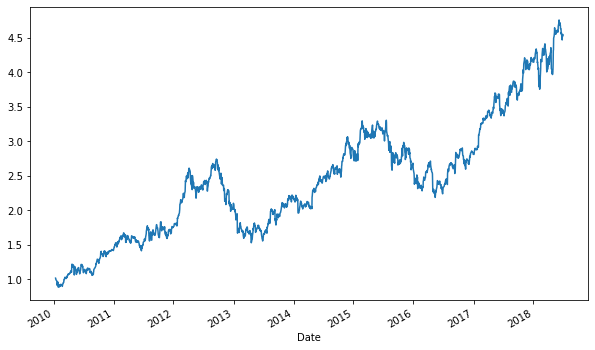

In [37]:
# 被动投资
data['Returns'].cumsum().apply(np.exp).plot(figsize=(10,6))

In [39]:
# SVC
from sklearn.svm import SVC

<AxesSubplot:xlabel='Date'>

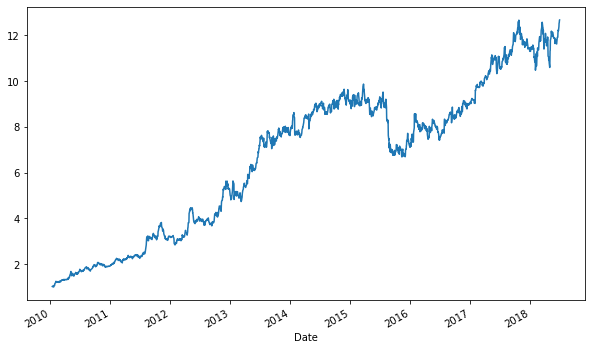

In [40]:
model = SVC(gamma='auto')
model.fit(data[cols], np.sign(data['Returns']))
data['Prediction'] = model.predict(data[cols])
data['Strategy'] = data['Prediction'] * data['Returns']
data['Strategy'].cumsum().apply(np.exp).plot(figsize=(10,6))

In [43]:
cols[:3]

['lag_1', 'lag_2', 'lag_3']

<AxesSubplot:xlabel='Date'>

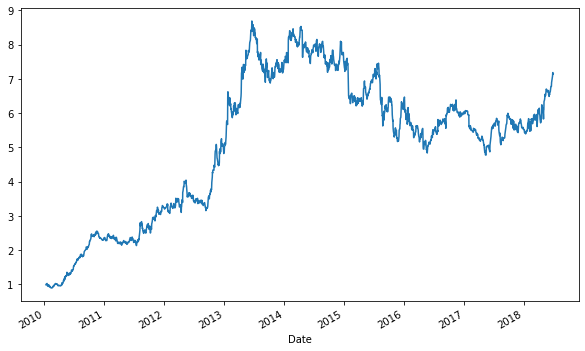

In [44]:
model.fit(data[cols[:3]], np.sign(data['Returns']))
data['Prediction'] = model.predict(data[cols[:3]])
data['Strategy'] = data['Prediction'] * data['Returns']
data['Strategy'].cumsum().apply(np.exp).plot(figsize=(10,6))